# Stage 2
### Kelompok 8IG FIVE

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))
    
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

## Dataset E-commerce Shipping Data

In [7]:
df = pd.read_csv('E-Commerce Shipping Data.csv')
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


## Statistical Summary

In [9]:
# Pengelompokan kolom berdasarkan jenisnya
numericals = ['Customer_care_calls','Cost_of_the_Product','Prior_purchases','Discount_offered','Weight_in_gms','Customer_rating','Reached.on.Time_Y.N']
categoricals = ['Warehouse_block','Mode_of_Shipment','Product_importance','Gender']

## Data Cleansing

### Handle Missing Value
`Pada Stage 1 Semua kolom tidak memiliki null/missing values (Non-Null Count < Jumlah Baris)`

### Handle Duplicated Data
`Pada Stage 1 Semua tipe data sesuai dan tidak ada duplikasi data`

### Handle Outlier
Outlier terlihat pada kolom `Prior_purchase` dan `Discount_offered` <br>
Menggunakan Z-score filtering

In [10]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in numericals:
    zscore = abs(st.zscore(df[col])) # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 10999
Jumlah baris setelah memfilter outlier: 10642


### Feature Transformation
Pada proses ini melakukan featrue transformation <br>
Ada Log/Exp Transformation dan Normalization

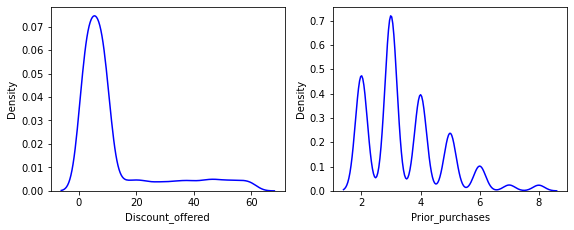

In [11]:
#Distribusi Discount Offered dan Prior purchases (Apakah cenderung atau Normal)
features = ['Discount_offered', 'Prior_purchases']
plt.figure(figsize=(12, 6))
for i in range (0, len(features)):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(x=df[features[i]], color='blue')
    plt.xlabel(features[i])
    plt.tight_layout()

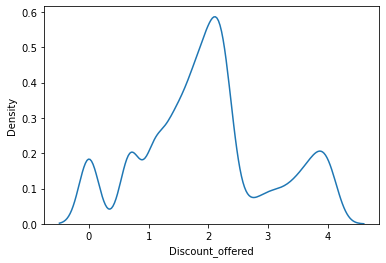

In [12]:
#Log Transformation
sns.kdeplot(np.log(df['Discount_offered']));

Berdasarkan figure diatas, setelah ditransform dengan log, distribusi data mendekati normal

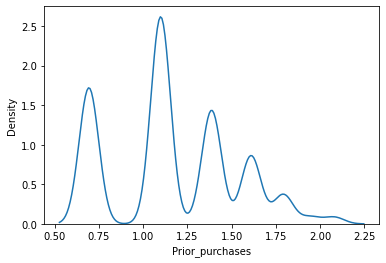

In [13]:
sns.kdeplot(np.log(df['Prior_purchases']));

Berdasarkan figure diatas, setelah ditransform dengan log, distribusi data tidak ada perubahan dengan sebelum di log

In [14]:
#Masih belum Normal namun masih bisa dilakukan Normalization

In [15]:
#Transformasi Feature yang cenderung skewed berdasarkan visual sebelumnya
df['log_Discount_offered'] = np.log(df['Discount_offered'])

In [16]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,log_Discount_offered
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,3.784190
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,4.077537
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,3.871201
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,2.302585
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,3.828641


### Feature Encoding
Mentransformasi feature categorical/yang berisi nilai unik menjadi numerical

In [17]:
categoricals = ['Warehouse_block','Mode_of_Shipment','Product_importance','Gender']

for col in categoricals:
  print(f'value counts of column {col}')
  print(df[col].value_counts())
  print('---'*10, '\n')

value counts of column Warehouse_block
F    3539
B    1778
D    1777
A    1777
C    1771
Name: Warehouse_block, dtype: int64
------------------------------ 

value counts of column Mode_of_Shipment
Ship      7211
Flight    1728
Road      1703
Name: Mode_of_Shipment, dtype: int64
------------------------------ 

value counts of column Product_importance
low       5173
medium    4587
high       882
Name: Product_importance, dtype: int64
------------------------------ 

value counts of column Gender
F    5356
M    5286
Name: Gender, dtype: int64
------------------------------ 



Strategi encoding
* `Gender` \: label encoding
* `Warehouse_block`,`Mode_of_Shipment` & `Product_importance` \: One Hot Encoding

In [18]:
mapping_Gender = {
    'F' : 0,
    'M' : 1
}

mapping_Warehouse_block = {
    'A' : 0,
    'B' : 1,
    'C' : 2,
    'D' : 3,
    'F' : 4
}

mapping_Mode_of_Shipment = {
    'Ship' : 0,
    'Flight' : 1,
    'Road' : 2
}

mapping_Product_importance = {
    'low' : 0,
    'medium' : 1,
    'high' : 2
}

df['Gender'] = df['Gender'].map(mapping_Gender)
df['Warehouse_block'] = df['Warehouse_block'].map(mapping_Warehouse_block)
df['Mode_of_Shipment'] = df['Mode_of_Shipment'].map(mapping_Mode_of_Shipment)
df['Product_importance'] = df['Product_importance'].map(mapping_Product_importance)

In [19]:
for cat in ['Warehouse_block', 'Mode_of_Shipment','Product_importance']:
    onehots = pd.get_dummies(df[cat], prefix=cat)
    df = df.join(onehots)

### Feature Extraction
Menambah feature baru berdasarkan dari feature yang ada

In [20]:
df['Cost_product_after_discount'] = df['Cost_of_the_Product'] - df['Discount_offered']
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,...,Warehouse_block_2,Warehouse_block_3,Warehouse_block_4,Mode_of_Shipment_0,Mode_of_Shipment_1,Mode_of_Shipment_2,Product_importance_0,Product_importance_1,Product_importance_2,Cost_product_after_discount
0,1,3,1,4,2,177,3,0,0,44,...,0,1,0,0,1,0,1,0,0,133
1,2,4,1,4,5,216,2,0,1,59,...,0,0,1,0,1,0,1,0,0,157
2,3,0,1,2,2,183,4,0,1,48,...,0,0,0,0,1,0,1,0,0,135
3,4,1,1,3,3,176,4,1,1,10,...,0,0,0,0,1,0,0,1,0,166
4,5,2,1,2,2,184,3,1,0,46,...,1,0,0,0,1,0,0,1,0,138


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10642 entries, 0 to 10998
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           10642 non-null  int64  
 1   Warehouse_block              10642 non-null  int64  
 2   Mode_of_Shipment             10642 non-null  int64  
 3   Customer_care_calls          10642 non-null  int64  
 4   Customer_rating              10642 non-null  int64  
 5   Cost_of_the_Product          10642 non-null  int64  
 6   Prior_purchases              10642 non-null  int64  
 7   Product_importance           10642 non-null  int64  
 8   Gender                       10642 non-null  int64  
 9   Discount_offered             10642 non-null  int64  
 10  Weight_in_gms                10642 non-null  int64  
 11  Reached.on.Time_Y.N          10642 non-null  int64  
 12  log_Discount_offered         10642 non-null  float64
 13  Warehouse_block_

### Feature Selection
Memilih feature yang akan digunakan untuk ditest dalam model yang akan digunakan

In [22]:
df_3 = df.drop(columns=['ID','Warehouse_block','Mode_of_Shipment','Product_importance','Discount_offered','Cost_of_the_Product','Customer_rating'])

In [23]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10642 entries, 0 to 10998
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_care_calls          10642 non-null  int64  
 1   Prior_purchases              10642 non-null  int64  
 2   Gender                       10642 non-null  int64  
 3   Weight_in_gms                10642 non-null  int64  
 4   Reached.on.Time_Y.N          10642 non-null  int64  
 5   log_Discount_offered         10642 non-null  float64
 6   Warehouse_block_0            10642 non-null  uint8  
 7   Warehouse_block_1            10642 non-null  uint8  
 8   Warehouse_block_2            10642 non-null  uint8  
 9   Warehouse_block_3            10642 non-null  uint8  
 10  Warehouse_block_4            10642 non-null  uint8  
 11  Mode_of_Shipment_0           10642 non-null  uint8  
 12  Mode_of_Shipment_1           10642 non-null  uint8  
 13  Mode_of_Shipment

In [24]:
df_3.columns = ['Customer_care_calls','Prior_purchases','Gender','Weight_in_gms','Reached.on.Time_Y.N','log_Discount_offered','Warehouse_block_A','Warehouse_block_B','Warehouse_block_C','Warehouse_block_D','Warehouse_block_F','Mode_of_Shipment_Ship','Mode_of_Shipment_Flight','Mode_of_Shipment_Road','Product_importance_low','Product_importance_medium','Product_importance_high','Cost_product_after_discount']

In [25]:
df_3.head()

,Customer_care_calls,Prior_purchases,Gender,Weight_in_gms,Reached.on.Time_Y.N,log_Discount_offered,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Ship,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Product_importance_low,Product_importance_medium,Product_importance_high,Cost_product_after_discount
0,4,3,0,1233,1,3.784190,0,0,0,1,0,0,1,0,1,0,0,133
1,4,2,1,3088,1,4.077537,0,0,0,0,1,0,1,0,1,0,0,157
2,2,4,1,3374,1,3.871201,1,0,0,0,0,0,1,0,1,0,0,135
3,3,4,1,1177,1,2.302585,0,1,0,0,0,0,1,0,0,1,0,166
4,2,3,0,2484,1,3.828641,0,0,1,0,0,0,1,0,0,1,0,138
